In [ ]:
#|default_exp core

In [ ]:
#|export
import math, typing, random, numpy as np
from collections.abc import Mapping
from copy import copy
from itertools import zip_longest
from functools import partial, wraps
from operator import attrgetter, itemgetter

import matplotlib.pyplot as plt
import fastcore.all as fc
from fastprogress import progress_bar, master_bar

import torch, torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import default_collate

from torcheval.metrics import Mean

In [ ]:
#|export
try: from accelerate import Accelerator
except: Accelerator=None

In [ ]:
from torcheval.metrics import  MulticlassAccuracy

## Introduction

This is the core functionality of the training framework developed interactively in the most recent FastAI course ('Impractical Deep Learning for Coders'). It is built on top of ideas from the fastai library, but is more flexible, and simpler.

In [ ]:
#| export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

## Datasets and Dataloaders

In [ ]:
from datasets import load_dataset
import torchvision.transforms.functional as TF

In [ ]:
ds = load_dataset('fashion_mnist')

In [ ]:
trn = ds['train']
val = ds['test']

In [ ]:
trn

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

A dataset needs to match the PyTorch dataset interface, which is very simple. It needs to have a `__len__` method, and a `__getitem__` method. The `__getitem__` method typically returns a tuple of (x, y) where x is the input and y is the target.

In [ ]:
#|export
class Dataset():
    "Simple dataset that combines two collections"
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

A dataset can optionally include transformation functions.

In [ ]:
#|export
class TfmDataset(Dataset):
    "Dataset subclass that transforms items"
    def __init__(self, x, y, tfm_x=None, tfm_y=None):
        super().__init__(x,y)
        self.tfm_x,self.tfm_y = tfm_x,tfm_y
        
    def __getitem__(self, i):
        x,y = self.x[i],self.y[i]
        return self.tfm_x(x) if self.tfm_x else x, self.tfm_y(y) if self.tfm_y else y

In [ ]:
trn_ds = TfmDataset(trn['image'], trn['label'], tfm_x=TF.to_tensor)
val_ds = TfmDataset(val['image'], val['label'], tfm_x=TF.to_tensor)

In [ ]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    "Convert train and validation datasets to data loaders"
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [ ]:
bs = 1024
trn_dl,val_dl = get_dls(trn_ds, val_ds, bs=bs)

In [ ]:
xb,yb = next(iter(trn_dl))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([9, 3, 1, 2, 4, 4, 2, 9, 8, 4]))

Huggingface datasets typically return dictionaries, so here's a collate function to handle them:

In [ ]:
#|export 
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

We can transform these dict-style datasets using `with_transform`:

In [ ]:
def transforms(b):
    b['image'] = [TF.to_tensor(o)*2-1 for o in b['image']]
    return b

In [ ]:
tds = ds.with_transform(transforms)

In [ ]:
#|export
class DataLoaders:
    "Convert a `DatasetDict` into a pair of `DataLoader`s"
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f))

We can recreate the same `DataLoader`s as before using this:

In [ ]:
dls = DataLoaders.from_dd(tds, batch_size=bs)

In [ ]:
xb,yb = next(iter(dls.train))
xb.shape,yb

(torch.Size([1024, 1, 28, 28]), tensor([3, 0, 4,  ..., 0, 8, 4]))

## Utilities for Displaying Images

We often work with images - this section has some convenient utilities for displaying them. At some point I'll add some examples :)

In [ ]:
#| export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

In [ ]:
#| export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

In [ ]:
#| export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

In [ ]:
#| export
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:typing.Union[int, None]=None, # Number of rows in grid
                ncols:typing.Union[int, None]=None, # Number of columns in grid (auto-calculated if None)
                titles:typing.Union[list, None]=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, [] if titles is None else titles, axs): show_image(im, ax=ax, title=t)

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray_r'

In [ ]:
feat = fc.nested_attr(dls, 'train.dataset.features')
names = feat['label'].names
titles = [names[i] for i in yb]

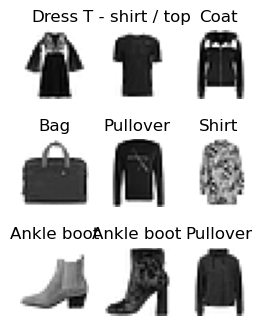

In [ ]:
show_images(xb[:9], titles=titles[:9], figsize=(3,4));

## Device management

Convenience functions related to device management. Note that if you do `from minai import *`  then def_device will be defined and will be used as the default in functions like to_device() unless you specify otherwise.

In [ ]:
#|export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#|export
def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

In [ ]:
#|export
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    return x.detach().cpu()

In [ ]:
#|export
def collate_device(b): return to_device(default_collate(b))

## The Learner 

The core of miniai is the Learner class. It binds together model, dataloaders, loss function and so on. The goal is to handle everything required for training a model while still providing complete control over any of the steps involved. This is done by leaning heavily on callbacks. 

It may be instructive here to look at how a single batch is processed (code from the Learner definition below):

```python
@with_cbs('batch')
def _one_batch(self):
    self.predict()
    self.callback('after_predict')
    self.get_loss()
    self.callback('after_loss')
    if self.training:
        self.backward()
        self.callback('after_backward')
        self.step()
        self.callback('after_step')
        self.zero_grad()
```

The `@with_cbs('batch')` decorator means that any of the models callbacks that define a `before_batch` or `after_batch` method will have said method called when appropriate. This allows you to do things like pre-process a batch of data before the model sees it, or log the loss after the batch has been processed. Within the `_one_batch` method, five special functions are called (predict, get_loss, backward, step, zero_grad). These are the five steps that are required for training a model. There are additional points where callbacks can be called, for example after the loss has been calculated but before the model has been updated. 

The default Learner doesn't even define these methods - instead, it looks to see if they are defined in any of its callbacks. If you're not planning on doing anything fancy, then TrainCB is all you need. It defines all of the methods above. Alternatively, you can use `TrainLearner` which is a subclass of Learner that defines all of the methods above.

What's the point? These choices mean that if you're just fitting a basic model then you can use TrainLearner or TrainCB and you don't need to worry about any of the details. BUT if you do want to go in and add something fancy, you now have that option. Need a custom step to modify gradients before they are applied? No problem - re-define the step method. Need to make sure everything is on the right device before calling the model? No problem - check out DeviceCB to see how easy it is to do this! 

### Callback Infrastructure

In [ ]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [ ]:
#|export
class Callback(): order = 0

In [ ]:
#|export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In [ ]:
#|export
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

### Learner class and friends

In [ ]:
#|export
from itertools import cycle

In [ ]:
#|export
class CycleDL():
    def __init__(self, items, sz=None):
        self.items = items
        self.sz = len(items) if sz is None else sz
        self.it = None

    def __len__(self): return len(self.items) if self.sz is None else self.sz
    def __iter__(self):
        if self.it is None: self.it = cycle(iter(self.items))
        for i in range(self.sz): yield next(self.it)

In [ ]:
d = CycleDL(range(10), 3)
[list(d) for _ in range(5)]

[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1], [2, 3, 4]]

In [ ]:
#|export
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD, epoch_sz=None):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.train_dl if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        self.train_dl = self.dls.train
        if self.epoch_sz is not None: self.train_dl = CycleDL(self.train_dl, self.epoch_sz)
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid:
                with torch.inference_mode(): self.one_epoch(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        self.cbs += cbs
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

In [ ]:
#|export
def _get_inp(b, n_inp, inp_nm):
    if inp_nm is not None: return [b[inp_nm]]
    return b[:n_inp]

def _get_lbl(b, n_inp, lbl_nm):
    if lbl_nm is not None: return [b[lbl_nm]]
    return b[n_inp:]

def _get_preds(b, preds_nm):
    return b if preds_nm is None else getattr(b, preds_nm)

In [ ]:
#|export
class TrainLearner(Learner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=torch.optim.SGD, epoch_sz=None,
                 n_inp=1, inp_nm=None, lbl_nm=None, preds_nm=None):
        super().__init__(model, dls, loss_func, lr, cbs, opt_func=opt_func, epoch_sz=epoch_sz)
        self.n_inp,self.inp_nm,self.lbl_nm,self.preds_nm = n_inp,inp_nm,lbl_nm,preds_nm

    def predict(self):
        inps = _get_inp(self.batch, self.n_inp, self.inp_nm)
        self.preds = self.model(*inps)

    def get_loss(self):
        lbls = _get_lbl(self.batch, self.n_inp, self.lbl_nm)
        preds = _get_preds(self.preds, self.preds_nm)
        self.loss = self.loss_func(preds, *lbls)

    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [ ]:
#|export
class TrainCB(Callback):
    def __init__(self, n_inp=1, inp_nm=None, lbl_nm=None, preds_nm=None):
        self.n_inp = n_inp
        self.n_inp,self.inp_nm,self.lbl_nm,self.preds_nm = n_inp,inp_nm,lbl_nm,preds_nm

    def predict(self, learn):
        inps = _get_inp(learn.batch, self.n_inp, self.inp_nm)
        learn.preds = learn.model(*inps)

    def get_loss(self, learn):
        lbls = _get_lbl(learn.batch, self.n_inp, self.lbl_nm)
        preds = _get_preds(learn.preds, self.preds_nm)
        learn.loss = learn.loss_func(preds, *lbls)

    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [ ]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=torch.optim.SGD, epoch_sz=None,
                 n_inp=1, inp_nm=None, lbl_nm=None, preds_nm=None, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func=opt_func, epoch_sz=epoch_sz, n_inp=n_inp,
                        inp_nm=inp_nm, lbl_nm=lbl_nm, preds_nm=preds_nm)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters():
                if p.grad is not None:
                    p.grad.detach_()
                    p.grad *= self.mom

### Some useful callbacks

DeviceCB - makes sure everything is on the right device:

In [ ]:
#|export
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

Sometimes you only want to run a single batch, for example when debugging. This callback allows you to do that, making use of the CancelFitException:

In [ ]:
#|export
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()

We rely on torcheval metrics for calculating metrics. By defauly, adding a MetricsCB will track the loss. But you can feed in other metrics as needed:

In [ ]:
#|export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

ProgressCB is a simple callback that prints out the progress of training. It's not very sophisticated, but it's useful for debugging. Any metrics being tracked via MetricsCB will be printed out as well. And you can set plot=True to get a plot of the loss during training:

In [ ]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

There are callbacks for all sorts of things, here are some common ones.

In [ ]:
cbs = [
    TrainCB(), # Handles the core steps in the training loop
    DeviceCB(), # Puts data and model on GPU
    MetricsCB(accuracy=MulticlassAccuracy())
]

We'll try a very basic convnet:

In [ ]:
def conv(nin,nout):
    return [nn.Conv2d(nin, nout, kernel_size=3, stride=2, padding=1),
            nn.ReLU(), nn.BatchNorm2d(nout)]

def get_model():
    return nn.Sequential(*conv(1, 16), *conv(16,32), *conv(32,32),
                         nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(32,10))

In [ ]:
opt = partial(torch.optim.AdamW, betas=(0.9,0.95), eps=1e-5)
learn = Learner(get_model(), dls, nn.CrossEntropyLoss(), lr=0.05, cbs=cbs, opt_func=opt)

accuracy,loss,epoch,train
0.706,0.808,0,train
0.699,0.957,0,eval


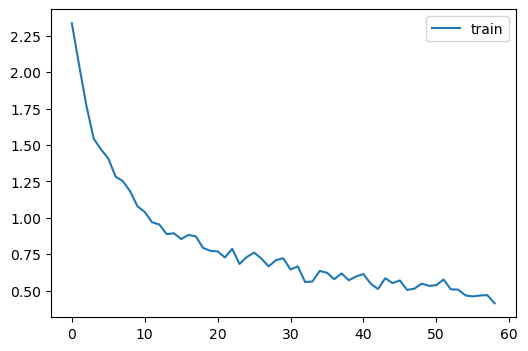

In [ ]:
learn.fit(1, cbs=[ProgressCB(plot=True)])

In [ ]:
#| export
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_inps,self.all_preds,self.all_targs = [],[],[]
    def after_batch(self, learn):
        self.all_inps. append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))
    def after_fit(self, learn):
        self.all_preds,self.all_targs,self.all_inps = map(torch.cat, [self.all_preds,self.all_targs,self.all_inps])

In [ ]:
#| export
@fc.patch
def capture_preds(self: Learner, cbs=None, inps=False):
    cp = CapturePreds()
    with torch.inference_mode(): self.fit(1, train=False, cbs=[cp]+fc.L(cbs))
    res = cp.all_preds,cp.all_targs
    if inps: res = res+(cp.all_inps,)
    return res

In [ ]:
preds,targs = learn.capture_preds()
preds.shape,targs.shape

(torch.Size([10000, 10]), torch.Size([10000]))

In [ ]:
(preds.argmax(1)==targs).float().mean()

tensor(0.6987)

If you want logging more often than the end of each full pass through the data loader, set `epoch_sz` to be the number of batches you'd like to count as an "epoch".

In [ ]:
learn = Learner(get_model(), dls, nn.CrossEntropyLoss(), lr=0.05,
                cbs=cbs, opt_func=opt, epoch_sz=10)
learn.fit(3, cbs=[ProgressCB()])

accuracy,loss,epoch,train
0.398,1.579,0,train
0.517,1.706,0,eval
0.671,0.935,1,train
0.449,1.795,1,eval
0.729,0.733,2,train
0.712,0.810,2,eval


In [ ]:
#| export
@fc.patch
@fc.delegates(show_images)
def show_image_batch(self:Learner, max_n=9, cbs=None, **kwargs):
    self.fit(1, cbs=[SingleBatchCB()]+fc.L(cbs))
    xb,yb = self.batch
    feat = fc.nested_attr(self.dls, 'train.dataset.features')
    if feat is None: titles = np.array(yb)
    else:
        names = feat['label'].names
        titles = [names[i] for i in yb]
    show_images(xb[:max_n], titles=titles[:max_n], **kwargs)

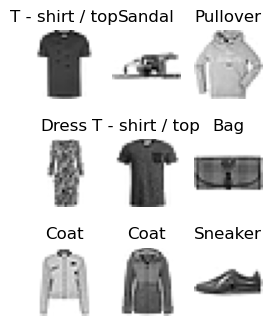

In [ ]:
learn.show_image_batch(figsize=(3,4))

### Learning Rate Finder

A useful method from FastAI, the learning rate finder tries batches at ever-increasing LRs and plots the loss. It's a good way to get a sense of what LR to use for training. Note that we also patch in the `lr_find` method to the Learner class, so you can call it directly.

In [ ]:
#|export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*self.max_mult:
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

In [ ]:
#|export
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

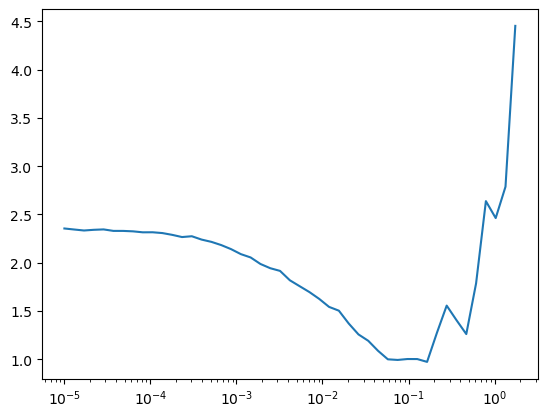

In [ ]:
learn = Learner(get_model(), dls, nn.CrossEntropyLoss(), lr=0.1, cbs=cbs, opt_func=opt)
learn.lr_find()

### Scheduling callbacks

In [ ]:
#|export
class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]
    
    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self))

    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [ ]:
#|export
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()      

In [ ]:
#|export  
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

In [ ]:
#|export
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn)

In [ ]:
#|export
class HasLearnCB(Callback):
    def before_fit(self, learn): self.learn = learn 
    def after_fit(self, learn): self.learn = None

### Accelerated training loops

In [ ]:
#|export 
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, dtype=torch.bfloat16):
        super().__init__(n_inp=n_inp)
        self.dtype=dtype
    
    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=self.dtype)
        self.autocast.__enter__()

    def after_loss(self, learn): self.autocast.__exit__(None, None, None)
        
    def backward(self, learn): self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

accuracy,loss,epoch,train
0.704,0.823,0,train
0.737,0.723,0,eval


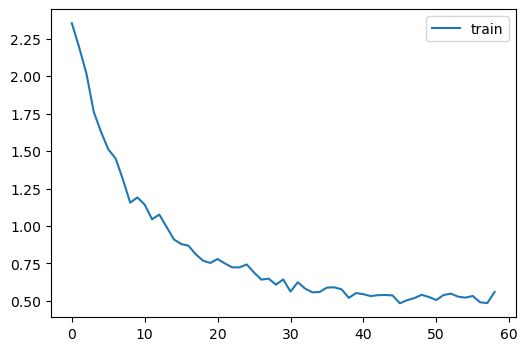

In [ ]:
cbs = [MixedPrecision(), DeviceCB(), MetricsCB(accuracy=MulticlassAccuracy())]
learn = Learner(get_model(), dls, nn.CrossEntropyLoss(), lr=0.05, cbs=cbs, opt_func=opt)
learn.fit(1, cbs=[ProgressCB(plot=True)])

In [ ]:
#|export
class AccelerateCB(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, mixed_precision="fp16"):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self, learn):
        learn.model,learn.opt,learn.dls.train,learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid)
    
    def after_fit(self, learn): learn.model = self.acc.unwrap_model(learn.model)
    def backward(self, learn): self.acc.backward(learn.loss)

## Hooks

In [ ]:
#| export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp).float()
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

In [ ]:
#| export
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

In [ ]:
#| export
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [ ]:
#| export
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [ ]:
#| export
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        if self.mods: mods=self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [ ]:
#| export
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

In [ ]:
#|export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [ ]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

In [ ]:
learn = Learner(get_model(), dls, nn.CrossEntropyLoss(), lr=0.05, cbs=cbs, opt_func=opt)

In [ ]:
learn.fit(1, cbs=[ProgressCB(), astats])

accuracy,loss,epoch,train
0.718,0.777,0,train
0.460,2.456,0,eval


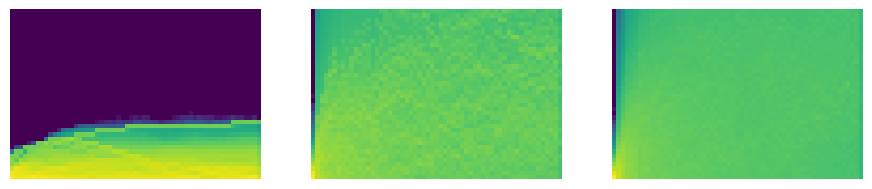

In [ ]:
plt.rc('image', cmap='viridis')
astats.color_dim()

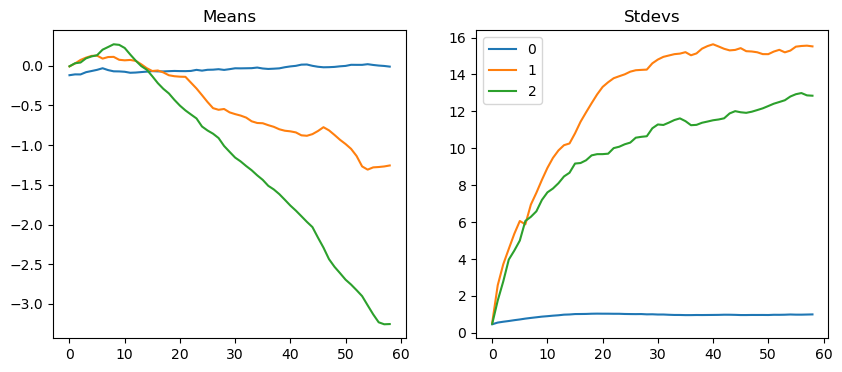

In [ ]:
astats.plot_stats()

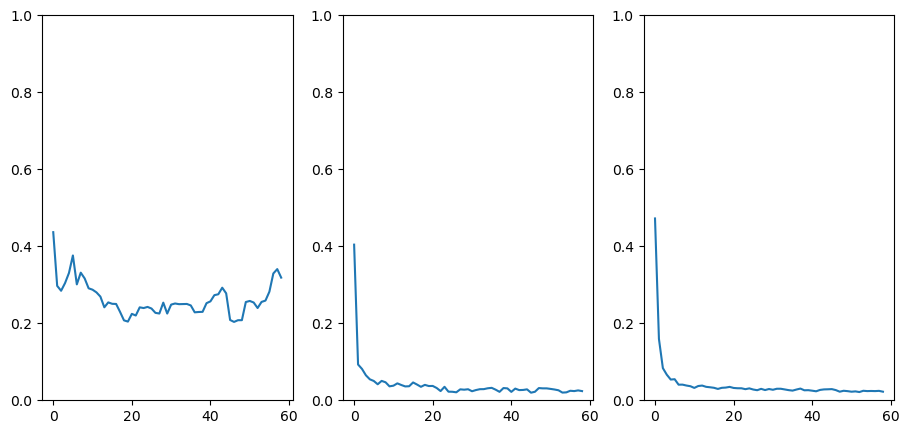

In [ ]:
astats.dead_chart()

In [ ]:
#|export
def _flops(x, h, w):
    if x.dim()<3: return x.numel()
    if x.dim()==4: return x.numel()*h*w

In [ ]:
#|export
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
    totp,totf = 0,0
    def _f(hook, mod, inp, outp):
        nonlocal res,totp,totf
        nparms = sum(o.numel() for o in mod.parameters())
        totp += nparms
        *_,h,w = outp.shape
        flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        totf += flops
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|{flops:.1f}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, cbs=SingleBatchCB())
    print(f"Tot params: {totp}; MFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [ ]:
learn.summary()

Tot params: 14538; MFLOPS: 0.4


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Conv2d|(1024, 1, 28, 28)|(1024, 16, 14, 14)|160|0.0|
|ReLU|(1024, 16, 14, 14)|(1024, 16, 14, 14)|0|0.0|
|BatchNorm2d|(1024, 16, 14, 14)|(1024, 16, 14, 14)|32|0.0|
|Conv2d|(1024, 16, 14, 14)|(1024, 32, 7, 7)|4640|0.2|
|ReLU|(1024, 32, 7, 7)|(1024, 32, 7, 7)|0|0.0|
|BatchNorm2d|(1024, 32, 7, 7)|(1024, 32, 7, 7)|64|0.0|
|Conv2d|(1024, 32, 7, 7)|(1024, 32, 4, 4)|9248|0.1|
|ReLU|(1024, 32, 4, 4)|(1024, 32, 4, 4)|0|0.0|
|BatchNorm2d|(1024, 32, 4, 4)|(1024, 32, 4, 4)|64|0.0|
|AdaptiveAvgPool2d|(1024, 32, 4, 4)|(1024, 32, 1, 1)|0|0.0|
|Flatten|(1024, 32, 1, 1)|(1024, 32)|0|0.0|
|Linear|(1024, 32)|(1024, 10)|330|0.0|


In [ ]:
#| export
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [ ]:
def _norm(b): return (b[0]-xmean)/xstd,b[1]
norm = BatchTransformCB(_norm)

In [ ]:
#|export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

## Data augmentation

In [ ]:
import random

In [ ]:
#|export
def _rand_erase1(x, pct, xm, xs, mn, mx):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx = int(random.random()*(1-pct)*x.shape[-2])
    sty = int(random.random()*(1-pct)*x.shape[-1])
    nn.init.normal_(x[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs)
    x.clamp_(mn, mx)

In [ ]:
#|export
def rand_erase(x, pct=0.2, min_num=0, max_num = 4):
    xm,xs,mn,mx = x.mean(),x.std(),x.min(),x.max()
    num = random.randint(min_num, max_num)
    for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
    return x

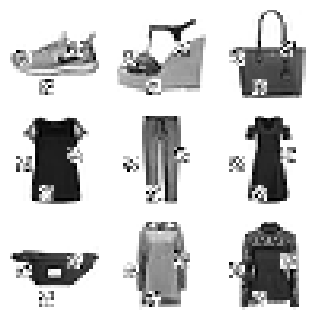

In [ ]:
plt.rcParams['image.cmap'] = 'gray_r'
xb,_ = next(iter(dls.train))
xbt = xb[:9]
rand_erase(xbt, 0.2, 3, 3)
show_images(xbt, imsize=1.3)

In [ ]:
#|export
class RandErase(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_erase(x, self.pct, self.max_num)

In [ ]:
#|export
def _rand_copy1(x, pct):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx1 = int(random.random()*(1-pct)*x.shape[-2])
    sty1 = int(random.random()*(1-pct)*x.shape[-1])
    stx2 = int(random.random()*(1-pct)*x.shape[-2])
    sty2 = int(random.random()*(1-pct)*x.shape[-1])
    x[:,:,stx1:stx1+szx,sty1:sty1+szy] = x[:,:,stx2:stx2+szx,sty2:sty2+szy]

In [ ]:
#|export
def rand_copy(x, pct=0.2, min_num=0, max_num=4):
    num = random.randint(min_num, max_num)
    for i in range(num): _rand_copy1(x, pct)
    return x

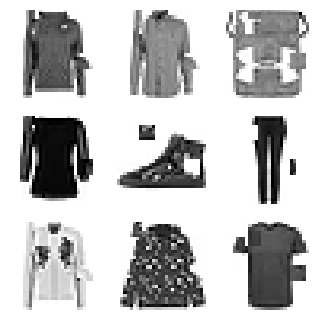

In [ ]:
xbt = xb[:9]
xb,_ = next(iter(dls.train))
rand_copy(xbt, 0.2, 3, 3)
show_images(xbt, imsize=1.3)

In [ ]:
#|export
class RandCopy(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_copy(x, self.pct, self.max_num)

## Clean memory

In [ ]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [ ]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [ ]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

## export -

In [ ]:
from nbdev import nbdev_export; nbdev_export()